## Installing Libraries


In [4]:
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import pandas as pd
import re
import os


## Setting Parameters

In [5]:
# setting parameters in the Hamiltonianin unit of f=GF/sqrt(2)/V (from paper)
angle = 26.56 / 180. * np.pi    # sin(2*angle)=0.8
wbar = 1.0                  # dm**2/(4*T*f)
tbar = 10000               # T/f

# creating simulation set up
dt = 0.01                   # time step size


## Momentum Lattice

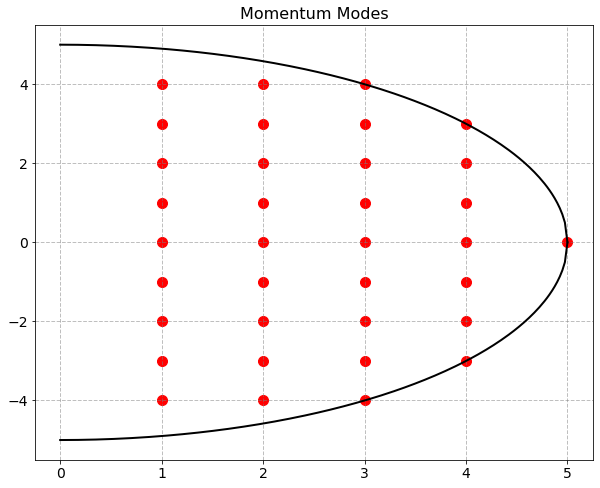

In [6]:
# setting file paths
file_dir = '/Users/ariellefrommer/Desktop/Neutrinos/KE_configurations/'
input_path = os.path.join(file_dir, 'P35.npy')
figure_path = os.path.join(file_dir, 'Plots/momentum_modes.png')

# loading in momentum lattice
P = np.load(input_path)

plt.figure(figsize = (10, 8), facecolor='white')

# plotting momentum modes
plt.grid(color = 'gray', linestyle = '--', linewidth = 1, alpha = 0.5)
plt.scatter(P[:,0], P[:,1], color = 'red', s = 100)

xs = np.linspace(0, P.max(), 200)
ys = np.sqrt(P.max()**2 - xs**2)
plt.plot(xs, ys, color = 'black', linewidth = 2)
plt.plot(xs, -ys, color = 'black', linewidth = 2)

plt.title('Momentum Modes', fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize = 14)

plt.savefig(figure_path, bbox_inches='tight', dpi = 200)
plt.show()


## State Configuration Class

In [7]:
# class to load in states and state information
class StateConfig:
    def __init__(self, file_dir):
        self.file_dir = file_dir                                 # file directory
        self.states_path = os.path.join(file_dir, 'states.npy')  # states file
        self.notes_path = os.path.join(file_dir, 'config.dat')   # notes file
        self.states = None                                       # all activated states
        self.notes = []                                          # notes list
        self.init_state = None                                   # initial state of system
        self.j_to_bstr = {}                                      # index to binary string list
        self.bstr_to_j = {}                                      # binary string to index list
        self.Ns = None                                           # number of activated states
        self.Nn = None                                           # number of neutrinos
        self.activated_bins = []                                 # number of activated bins
        
        # functions to load and process state information
        self.load_files()
        self.process_notes()
        self.j_to_bstr, self.bstr_to_j = self.generate_lists()
        
    # loading in states and state information
    def load_files(self):
        self.states = np.load(self.states_path)
        with open(self.notes_path, 'r') as file:
            for note in file:
                note = note.strip()
                self.notes.append(note)    
    
    # processing state information
    def process_notes(self):
        
        # number of neutrinos
        self.neutrino_number = self.notes[0]
        self.Nn = int(re.search(r'\d+', self.neutrino_number).group())

        # initial state
        self.init_s = self.notes[1]
        self.init_state = ','.join(re.findall(r'\d+', self.init_s))
        
        # bins visited
        self.bins_visited = self.notes[2]
        cleaned_str = re.sub(r'^.*?:\s*\[|\]$', '', self.bins_visited)
        self.activated_bins = [int(num) for num in re.split(r',\s*', cleaned_str) if num]
        
    # generating list of states
    def generate_lists(self):
        for i in range(len(self.states)):
            oc = ','.join(str(x) for x in self.states[i])
            self.bstr_to_j[oc] = i
            self.j_to_bstr[i] = oc         
        self.Ns = len(self.j_to_bstr)
        return self.j_to_bstr, self.bstr_to_j
        
    # printing list of states
    def print_basis(self):
        print(f'For {self.Nn} neutrinos with an initial state of [{self.init_state}], {self.Ns} states are activated:')
        for i in range(self.Ns):
            print(f'{i}th state: ({self.j_to_bstr[i]})')
    
    # setting class information
    def __repr__(self):
        return f'{self.neutrino_number}\n{self.init_s}\n{self.bins_visited}'
        

## Momenta Class

In [8]:
# class to make momentum pairs
class Momenta:
    def __init__(self, P):
        self.P = P                        # momentum matrix
        self.K = len(P)                   # number of momentum modes
        self.pairs = self.create_pairs()  # creating momentum pairs
        
    # defining momentum conservation function
    def p_is_equal(self, p1, p2):
        diff = p1 - p2
        return np.isclose(np.sum(np.abs(diff)), 0)

    # defining kinetic energy conservation function
    def ke_is_equal(self, p1, p2, p3, p4):
        
        # getting magnitudes of momenta
        k1 = np.linalg.norm(p1) 
        k2 = np.linalg.norm(p2) 
        k3 = np.linalg.norm(p3) 
        k4 = np.linalg.norm(p4)
        return np.isclose(k1 + k2 - k3 - k4, 0)
    
    # creating momentum pairs
    def create_pairs(self):
        P = self.P
        momenta = []
        
        # looping through momentum lattice
        for i1 in range(self.K):
            for i2 in range(self.K):
                for i3 in range(self.K):
                    for i4 in range(self.K):
                        
                        # momentum conservation
                        if self.p_is_equal(P[i1] + P[i2], P[i3] + P[i4]):
                            
                            # kinetic energy conservation
                            if self.ke_is_equal(P[i1], P[i2], P[i3], P[i4]):
                                momenta.append([i1, i2, i3, i4])
        
        # grabbing all momentum pairs
        return np.array(momenta)
    
    # setting momentum class information
    def __repr__(self):
        return f'Total number of conserved momenta pairs for {self.K} momentum modes: {len(self.pairs)}' 
    

## Hamiltonian Class

In [12]:
# class to calculate the Hamiltonian
class Hamiltonian:
    def __init__(self, momenta, config, dt):
        self.P = momenta.P                 # momentum lattice
        self.pairs = momenta.pairs         # momentum pairs
        self.K = momenta.K                 # number of momentum modes
        self.Ns = config.Ns                # number of states
        self.j_to_bstr = config.j_to_bstr  # index to binary string list
        self.bstr_to_j = config.bstr_to_j  # binary string to index list
        self.dt = dt                       # time step
        self.Nn = config.Nn                # number of neutrinos
        
        # creating Hamiltonian matrices as attributes
        self.H_full, self.U_full = self.construct_Hamiltonian()
        
    # state to binary conversion
    def b_to_j(self, b):
        oc = [i for i, bit in enumerate(b) if bit == 1]
        bstr = ','.join(str(x) for x in oc)
        return self.bstr_to_j[bstr]

    # binary to state conversion
    def j_to_b(self, j):
        bstr = self.j_to_bstr[j]
        oc = [int(x) for x in bstr.split(',')]
        b = [0] * self.K
        for i in range(len(oc)):
            b[oc[i]] = 1
        return b

    # applying a*(b1)a(b2) to a basis state
    def quad(self, b, basis):
        basis_copy = basis.copy()
        l = 1
        f = 1.0
        if basis_copy[b[1]] == 0:
            l = 0
        else:
            basis_copy[b[1]] = 0
            f *= (-1) ** np.sum(basis_copy[:b[1]])
        if basis_copy[b[0]] == 1:
            l = 0
        else:
            basis_copy[b[0]] = 1
            f *= (-1) ** np.sum(basis_copy[:b[0]])
        return l, f, basis_copy
    
    # applying a*(b1)a*(b2)a(b3)a(b4) to a basis state
    def quar(self, b, basis):
        basis_copy = basis.copy()
        l = 1
        f = 1.0
        if basis_copy[b[3]] == 0:
            l = 0
        else:
            basis_copy[b[3]] = 0
            f *= (-1) ** np.sum(basis_copy[:b[3]])
        if basis_copy[b[2]] == 0:
            l = 0
        else:
            basis_copy[b[2]] = 0
            f *= (-1) ** np.sum(basis_copy[:b[2]])
        if basis_copy[b[1]] == 1:
            l = 0
        else:
            basis_copy[b[1]] = 1
            f *= (-1) ** np.sum(basis_copy[:b[1]])
        if basis_copy[b[0]] == 1:
            l = 0
        else:
            basis_copy[b[0]] = 1
            f *= (-1) ** np.sum(basis_copy[:b[0]])
        return l, f, basis_copy

    # defining kinetic energy term applied to basis state j
    def kinetic(self, j):
        sin = self.j_to_b(j)
        state = np.zeros(self.Ns) * 1j

        # applying operators for all momentum states
        for p in range(self.K):
            absp = np.sqrt(np.sum(self.P[p] * self.P[p]))
            t, fa, sout = self.quad([p, p], sin)
            if t == 1:
                state[self.b_to_j(sout)] += fa * absp
        return state

    # defining spherical function for g factor calculation
    def p_spherical(self, p):
        absp = np.sqrt(np.sum(p*p))
        theta = np.arctan2(np.sqrt(p[0]**2+p[1]**2), p[2])
        phi = np.arctan2(p[1], p[0])
        return absp, theta, phi
   
    # calculating g factor for interaction potential
    def g_factor(self, p1, p2, q1, q2):
            absp1, tp1, pp1 = self.p_spherical(p1)
            absp2, tp2, pp2 = self.p_spherical(p2)
            absq1, tq1, pq1 = self.p_spherical(q1)
            absq2, tq2, pq2 = self.p_spherical(q2)
            fac1 = np.exp(-1j * pq1) * np.sin(tq1 / 2.) * np.cos(tq2 / 2.) - np.exp(-1j * pq2) * np.cos(tq1 / 2.) * np.sin(tq2 / 2.)
            fac2 = np.exp(1j * pp1) * np.sin(tp1 / 2.) * np.cos(tp2 / 2.) - np.exp(1j * pp2) * np.cos(tp1 / 2.) * np.sin(tp2 / 2.)
            return 2 * fac1 * fac2
    
     # defining the interaction potential function
    def interaction_potential(self, j):
        sin = self.j_to_b(j)
        state = np.zeros(self.Ns) * 1j
        for i in range(len(self.pairs)):
            p1, p2, q1, q2 = self.pairs[i]
            factor = - self.g_factor(self.P[p1], self.P[p2], self.P[q1], self.P[q2])
            t, fa, sout = self.quar([p1, p2, q1, q2], sin)
            if t == 1:
                state[self.b_to_j(sout)] += fa * factor
        return state
    
    # constructing Hamiltonian
    def construct_Hamiltonian(self):
        H_vac = np.zeros((self.Ns, self.Ns)) * 1j
        H_vv_full = np.zeros((self.Ns, self.Ns)) * 1j

        # calculating kinetic energy and interaction potential
        for i in range(self.Ns):
            H_vac[:, i] = self.kinetic(i)
            if i % 50 == 0:
                print(f'Constructing {i}th column of the Hamiltonian')
            H_vv_full[:, i] = self.interaction_potential(i)

        # creating Hamiltonian matrix
        H_full = H_vac + H_vv_full
        hvals_full, hvecs_full = np.linalg.eigh(H_full)
        U_full = hvecs_full @ np.diag(np.exp(-self.dt * hvals_full * 1j)) @ hvecs_full.conj().T
        return H_full, U_full
    

In [44]:
# class to time-evolve the system and plot observables
class TimeEvolution:
    def __init__(self, init_state, Nt, hamiltonian):
        self.init_state = config.init_state                                # initial state
        self.Nt = Nt                                                       # number of time steps
        self.bstr_to_j = hamiltonian.bstr_to_j                             # binary string to index list
        self.Ns = hamiltonian.Ns                                           # number of states
        self.dt = hamiltonian.dt                                           # time step
        self.K = hamiltonian.K                                             # number of bins
        self.Nn = hamiltonian.Nn                                           # number of neutrinos
        self.U_full = hamiltonian.U_full                                   # Hamiltonian matrix     
        self.j_to_b = hamiltonian.j_to_b                                   # binary to state conversion
        
        # creating probability amplitudes, number operators, and time as attributes 
        self.c_full, self.obs_store_full = self.time_evolve()               
        self.time = self.obs_store_full[:, self.K]                                          
        
    # norm and observables of interest
    def norm(self, state):
        return np.sqrt(np.sum(state * state.conj()))

    # input is the state vector, returns the # of neutrino in each bin
    def observable(self, state):
        obs = np.zeros(self.K)
        for i in range(self.Ns):
            binary = self.j_to_b(i)
            obs += np.abs(state[i])**2 * np.array(binary)
        return obs
    
    # time-evolving the system
    def time_evolve(self):
        
        # preparing functions to store amplitudes and number operators
        c_full = np.zeros((self.Nt, self.Ns))
        obs_store_full = np.zeros((self.Nt, self.K + 1))

        # creating array for storing the state, and choose the initial state
        initbin = self.init_state
        initj = self.bstr_to_j[initbin]
        state_full = np.zeros(self.Ns) * 1j
        state_full[initj] = 1.0 

        # calculating probability amplitudes
        for i in range(self.Nt):
            state_full = self.U_full @ state_full
            n_full = self.norm(state_full)
            if abs(n_full - 1.) > 1e-5:
                print('Norm off by > 1e-5 at time ', i*dt)
                break

            # storing amplitudes and time
            obs_full = self.observable(state_full)
            obs_store_full[i, :self.K] = obs_full
            obs_store_full[i, self.K] = i*dt
            c_full[i, :] = np.abs(state_full)**2
        return c_full, obs_store_full
        
    # plotting Hamiltonian
    def plot_Hamiltonian(self, file_path):
        
        # creating figure
        fig = plt.figure(figsize = (12, 8))
        gs = fig.add_gridspec(1, 1)
        axs = gs.subplots()
        
        fig.patch.set_facecolor('white')
        axs.set_facecolor('white')
        
        # indices to be plotted
        states = range(self.Ns)
        
        # labeling states
        labels = [f'{states[i]}th state' for i in states]
            
        # plotting Hamiltonian
        for idx, label in enumerate(labels):
            axs.plot(self.time, self.c_full[:, states[idx]], label = label)

        # plotting sum of specified states for Full Hamiltonian
        axs.plot(self.time, np.sum(self.c_full[:, states], axis=1), label='Sum')
       
        # setting subplot parameters
        axs.set_title(f'Full Hamiltonian with {self.Nn} Neutrinos and {self.Ns} States', fontsize = 14)
        axs.set_xlabel('time ($\epsilon$)', fontsize = 14)
        axs.set_ylabel('Amplitude', fontsize = 14)
        
        # setting global parameters
        plt.tick_params(axis='both', which='major', labelsize = 12)
        legend = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0125), ncol = 4,  frameon=True)
        legend.get_frame().set_edgecolor('black')
        
        # saving the plot
        file_path = os.path.join(file_path, 'Hamiltonian.png')
        plt.savefig(file_path, bbox_inches='tight', dpi = 200)
        
        # displaying and closing the plot
        plt.show()
        plt.close()
    
    # plotting number operators
    def plot_number_operators(self, file_path):
                
        # creating figure
        fig = plt.figure(figsize = (12, 8))
        gs = fig.add_gridspec(1, 1)
        axs = gs.subplots()
        
        fig.patch.set_facecolor('white')
        axs.set_facecolor('white')
                
        # choosing a colormap
        colormap = plt.get_cmap('tab20')

        # generating colors from the colormap
        colors = [colormap(i / self.K) for i in range(self.K)]
        
        # indices to be plotted
        bins = range(self.K)
            
        # labeling bins
        labels = [f'Bin {bins[i]}' for i in bins]

        # plotting number operators
        for idx, (label, color) in enumerate(zip(labels, colors)):
            axs.plot(self.time, self.obs_store_full[:, bins[idx]], label = label, color = color)

        # setting subplot parameters
        axs.set_title(f'Number Operators with {self.Nn} Neutrinos and {self.Ns} States', fontsize = 16)
        axs.set_xlabel('time ($\epsilon$)', fontsize = 14)
        axs.set_ylabel('$N_i$', fontsize = 14)
        
        # setting global parameters
        plt.tick_params(axis='both', which='major', labelsize = 14)
        legend = plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0125), ncol = 2, frameon=True)
        legend.get_frame().set_edgecolor('black')
        
        # saving the plot
        file_path = os.path.join(file_path, 'number_operators.png')
        plt.savefig(file_path, bbox_inches = 'tight', dpi = 200)
        
        # displaying and closing the plot
        plt.show()
        plt.close()
        

## Creating Momenta Pairs

In [11]:
%%time

# creating a momentum object
momenta = Momenta(P)

# printing the number of momentum pairs
print(momenta)


Total number of conserved momenta pairs for 35 momentum modes: 2727
CPU times: user 37.4 s, sys: 41.9 ms, total: 37.4 s
Wall time: 37.5 s


## 10 Neutrinos with 142 States

In [14]:
# setting file path 
file_path = os.path.join(file_dir, 'N10_s142')

# loading in state information
config = StateConfig(file_path)
print(config, '\n')

# printing the activated states
config.print_basis()

init_state = config.init_state


Number of neutrinos: 10
Initial state: [ 1  8 14 17 20 24 26 27 30 31]
Activated bins: [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34] 

For 10 neutrinos with an initial state of [1,8,14,17,20,24,26,27,30,31], 142 states are activated:
0th state: (1,8,14,17,20,24,26,27,30,31)
1th state: (1,7,14,17,20,25,26,27,30,31)
2th state: (1,9,14,17,20,24,25,27,30,31)
3th state: (1,10,14,17,20,24,25,26,30,31)
4th state: (1,8,11,17,23,24,26,27,30,31)
5th state: (1,8,14,17,20,21,27,29,30,31)
6th state: (1,8,14,17,20,21,26,27,30,34)
7th state: (1,7,11,17,23,25,26,27,30,31)
8th state: (1,9,11,17,23,24,25,27,30,31)
9th state: (1,9,14,17,20,21,25,27,30,34)
10th state: (1,10,11,17,23,24,25,26,30,31)
11th state: (1,10,14,17,20,21,25,29,30,31)
12th state: (1,10,14,17,20,21,25,26,30,34)
13th state: (1,8,11,17,21,23,27,29,30,31)
14th state: (1,8,11,17,21,23,26,27,30,34)
15th state: (1,8,12,17,20,23,27,29,30,31)
16th state: (2,8,14,17,20,21,26,27,30,33)
17th st

In [15]:
%%time

# creating Hamiltonian object and diagonalizing
hamiltonian = Hamiltonian(momenta, config, dt)

# printing Hamiltonian
print('\n', hamiltonian.H_full)


Constructing 0th column of the Hamiltonian
Constructing 50th column of the Hamiltonian
Constructing 100th column of the Hamiltonian

 [[113.98222657+0.j           4.99473319+1.66491106j
    3.15309193-0.63061839j ...   0.        +0.j
    0.        +0.j           0.        +0.j        ]
 [  4.99473319-1.66491106j 116.79827354+0.j
   -3.9037418 +2.2307096j  ...   0.        +0.j
    0.        +0.j           0.        +0.j        ]
 [  3.15309193+0.63061839j  -3.9037418 -2.2307096j
  111.27683712+0.j         ...   0.        +0.j
    0.        +0.j           0.        +0.j        ]
 ...
 [  0.        +0.j           0.        +0.j
    0.        +0.j         ... 114.89981568+0.j
    0.        +0.j           0.        +0.j        ]
 [  0.        +0.j           0.        +0.j
    0.        +0.j         ...   0.        +0.j
  115.35214468+0.j           1.97770876-0.98885438j]
 [  0.        +0.j           0.        +0.j
    0.        +0.j         ...   0.        +0.j
    1.97770876+0.98885438j 11

In [45]:
# creating a time-evolution object which computes probability amplitude and number operators
te = TimeEvolution(config.init_state, 1000, hamiltonian)


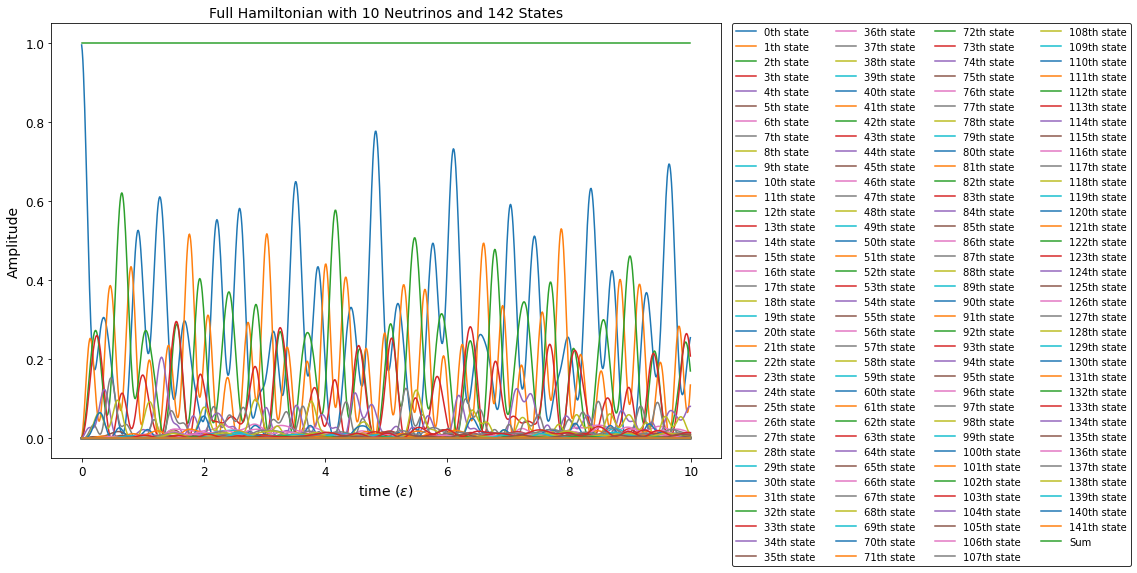

In [46]:
# plotting Hamiltonian
te.plot_Hamiltonian(file_path)


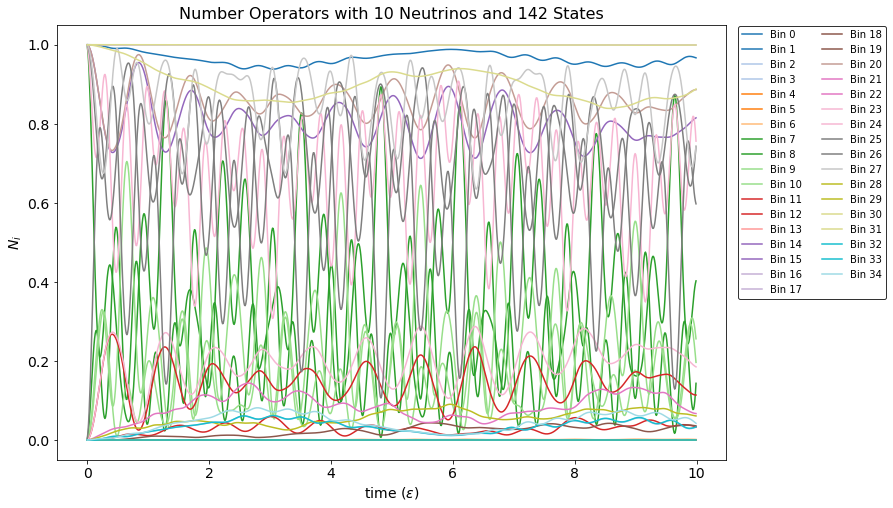

In [43]:
# plotting number operators
te.plot_number_operators(file_path)


## 10 Neutrinos with 70 States

In [26]:
# setting file path 
file_path = os.path.join(file_dir, 'N10_s70')

# loading in state information
config = StateConfig(file_path)
print(config, '\n')

# printing the activated states
config.print_basis()


Number of neutrinos: 10
Initial state: [ 1  2 14 17 20 24 25 27 28 31]
Activated bins: [1, 2, 3, 6, 7, 8, 10, 11, 12, 13, 14, 17, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34] 

For 10 neutrinos with an initial state of [1,2,14,17,20,24,25,27,28,31], 70 states are activated:
0th state: (1,2,14,17,20,24,25,27,28,31)
1th state: (1,2,11,17,23,24,25,27,28,31)
2th state: (1,2,14,17,20,21,25,27,28,34)
3th state: (1,2,14,17,20,22,24,25,31,33)
4th state: (1,2,11,17,21,23,25,27,28,34)
5th state: (1,2,11,17,22,23,24,25,31,33)
6th state: (1,2,12,17,20,23,25,27,28,34)
7th state: (1,2,14,17,20,21,22,25,33,34)
8th state: (1,3,14,17,19,20,24,25,31,33)
9th state: (1,2,13,17,20,23,24,25,31,33)
10th state: (1,2,11,17,21,22,23,25,33,34)
11th state: (1,3,11,17,19,23,24,25,31,33)
12th state: (1,6,7,17,20,23,25,27,28,34)
13th state: (1,2,12,17,20,22,23,25,33,34)
14th state: (1,3,14,17,19,20,21,25,33,34)
15th state: (1,2,13,17,20,21,23,25,33,34)
16th state: (1,6,14,17,19,20,24,25,28,33)
17th state: (2,3,10

In [27]:
%%time

# creating Hamiltonian object and diagonalizing
hamiltonian = Hamiltonian(momenta, config, dt)


Constructing 0th column of the Hamiltonian
Constructing 50th column of the Hamiltonian
CPU times: user 14.1 s, sys: 74.8 ms, total: 14.1 s
Wall time: 14.1 s


In [31]:
# creating a time-evolution object which computes probability amplitude and number operators
te = TimeEvolution(init_state, 3000, hamiltonian)


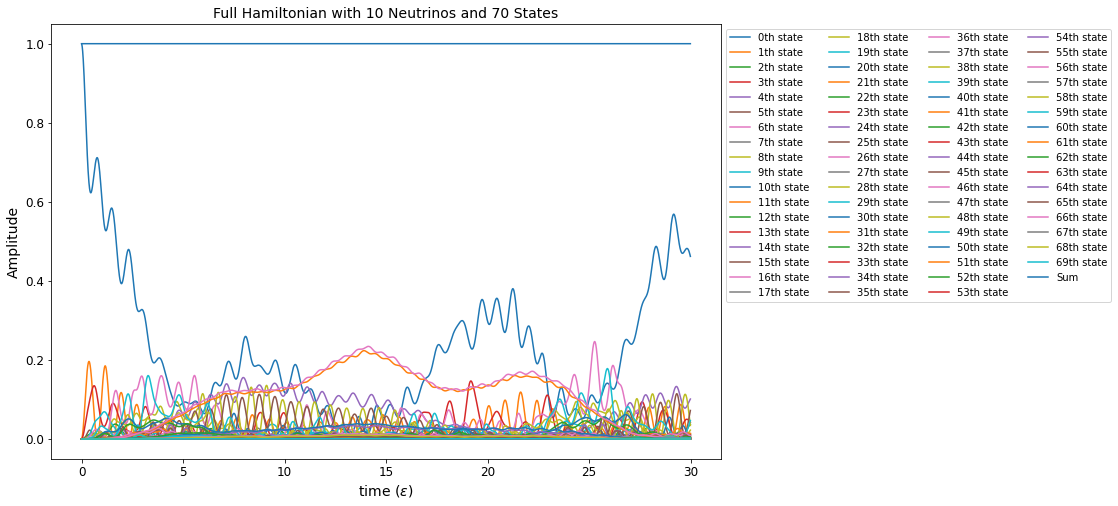

In [32]:
# plotting Hamiltonian
te.plot_Hamiltonian(file_path)


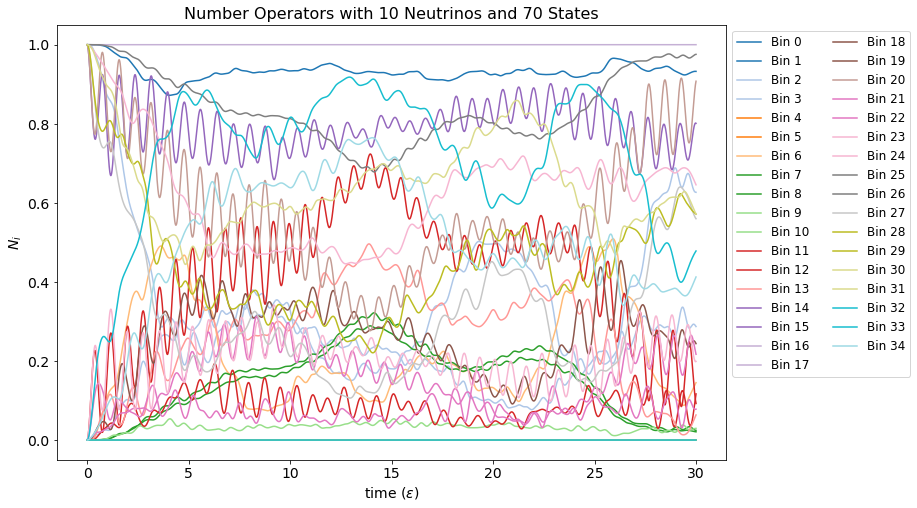

In [33]:
# plotting number operators
te.plot_number_operators(file_path)


## 18 Neutrinos, 1600 States

In [36]:
# setting file path 
file_path = os.path.join(file_dir, 'N18_s1600')

# loading in state information
config = StateConfig(file_path)
print(config, '\n')

# printing the activated states
config.print_basis()


Number of neutrinos: 18
Initial state: [ 0  1  2  8 10 12 14 15 17 20 24 25 26 27 28 30 31 34]
Activated bins: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] 

For 18 neutrinos with an initial state of [0,1,2,8,10,12,14,15,17,20,24,25,26,27,28,30,31,34], 1600 states are activated:
0th state: (0,1,2,8,10,12,14,15,17,20,24,25,26,27,28,30,31,34)
1th state: (0,1,6,7,8,10,14,15,17,20,24,25,26,27,28,30,31,34)
2th state: (0,1,2,8,10,11,14,15,17,21,24,25,26,27,28,30,31,34)
3th state: (0,1,2,8,10,11,12,15,17,23,24,25,26,27,28,30,31,34)
4th state: (0,1,2,8,10,12,14,15,17,20,21,25,27,28,29,30,31,34)
5th state: (0,1,2,8,10,12,14,15,17,20,22,24,25,26,30,31,33,34)
6th state: (1,2,6,7,8,10,14,15,17,20,24,25,26,27,28,30,31,32)
7th state: (0,2,6,7,8,10,14,15,17,20,24,25,26,27,28,30,31,33)
8th state: (0,1,6,7,8,10,11,15,17,23,24,25,26,27,28,30,31,34)
9th state: (0,1,6,7,8,10,14,15,17,20,21,25,27,28,29,30,31,34)
10th stat

In [37]:
%%time

# creating Hamiltonian object and diagonalizing
hamiltonian = Hamiltonian(momenta, config, dt)


Constructing 0th column of the Hamiltonian
Constructing 50th column of the Hamiltonian
Constructing 100th column of the Hamiltonian
Constructing 150th column of the Hamiltonian
Constructing 200th column of the Hamiltonian
Constructing 250th column of the Hamiltonian
Constructing 300th column of the Hamiltonian
Constructing 350th column of the Hamiltonian
Constructing 400th column of the Hamiltonian
Constructing 450th column of the Hamiltonian
Constructing 500th column of the Hamiltonian
Constructing 550th column of the Hamiltonian
Constructing 600th column of the Hamiltonian
Constructing 650th column of the Hamiltonian
Constructing 700th column of the Hamiltonian
Constructing 750th column of the Hamiltonian
Constructing 800th column of the Hamiltonian
Constructing 850th column of the Hamiltonian
Constructing 900th column of the Hamiltonian
Constructing 950th column of the Hamiltonian
Constructing 1000th column of the Hamiltonian
Constructing 1050th column of the Hamiltonian
Constructin

In [39]:
%%time

# creating a time-evolution object which computes probability amplitude and number operators
te = TimeEvolution(init_state, 3000, hamiltonian)


CPU times: user 8min 18s, sys: 2min 17s, total: 10min 35s
Wall time: 1min 41s


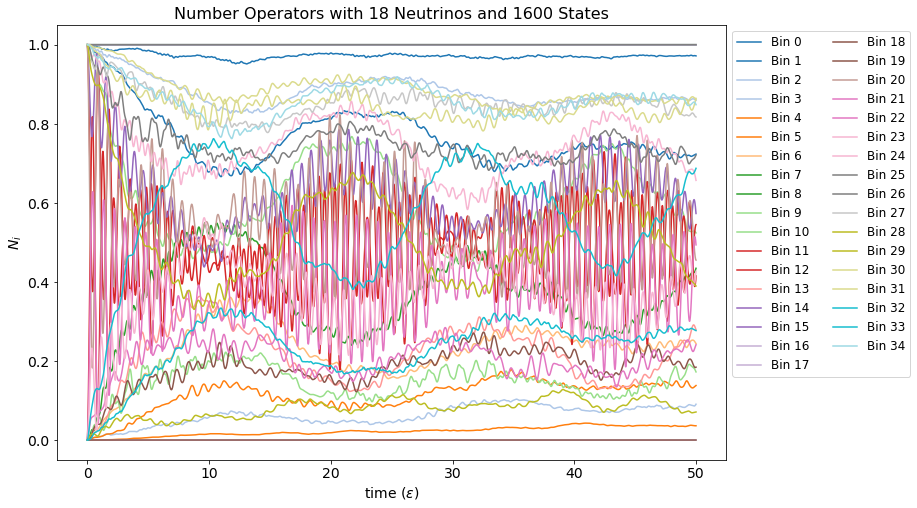

In [40]:
# plotting number operators
te.plot_number_operators(file_path)


## 12 Neutrinos, 518 States

In [41]:
# setting file path 
file_path = os.path.join(file_dir, 'N12_s518')

# loading in state information
config = StateConfig(file_path)
print(config, '\n')

# printing the activated states
config.print_basis()


Number of neutrinos: 12
Initial state: [ 0  1  2  8 14 17 20 24 26 27 30 31]
Activated bins: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34] 

For 12 neutrinos with an initial state of [0,1,2,8,14,17,20,24,26,27,30,31], 518 states are activated:
0th state: (0,1,2,8,14,17,20,24,26,27,30,31)
1th state: (0,1,2,7,14,17,20,25,26,27,30,31)
2th state: (0,1,2,9,14,17,20,24,25,27,30,31)
3th state: (0,1,2,10,14,17,20,24,25,26,30,31)
4th state: (0,1,2,8,11,17,23,24,26,27,30,31)
5th state: (0,1,2,8,14,17,20,21,27,29,30,31)
6th state: (0,1,2,8,14,17,20,21,26,27,30,34)
7th state: (0,1,2,7,11,17,23,25,26,27,30,31)
8th state: (0,1,4,6,14,17,20,24,25,27,30,31)
9th state: (0,1,2,9,11,17,23,24,25,27,30,31)
10th state: (0,1,2,9,14,17,20,21,25,27,30,34)
11th state: (0,1,2,10,11,17,23,24,25,26,30,31)
12th state: (0,1,2,10,14,17,20,21,25,29,30,31)
13th state: (0,1,2,10,14,17,20,21,25,26,30,34)
14th state: (0,1,2,8,11,17,21,23,27,29,30,31)
15th state: (0

In [42]:
%%time

# creating Hamiltonian object and diagonalizing
hamiltonian = Hamiltonian(momenta, config, dt)


Constructing 0th column of the Hamiltonian
Constructing 50th column of the Hamiltonian
Constructing 100th column of the Hamiltonian
Constructing 150th column of the Hamiltonian
Constructing 200th column of the Hamiltonian
Constructing 250th column of the Hamiltonian
Constructing 300th column of the Hamiltonian
Constructing 350th column of the Hamiltonian
Constructing 400th column of the Hamiltonian
Constructing 450th column of the Hamiltonian
Constructing 500th column of the Hamiltonian
CPU times: user 1min 44s, sys: 302 ms, total: 1min 44s
Wall time: 1min 43s


In [46]:
%%time

# creating a time-evolution object which computes probability amplitude and number operators
te = TimeEvolution(init_state, 1000, hamiltonian)


CPU times: user 24.8 s, sys: 7.07 s, total: 31.9 s
Wall time: 5.71 s


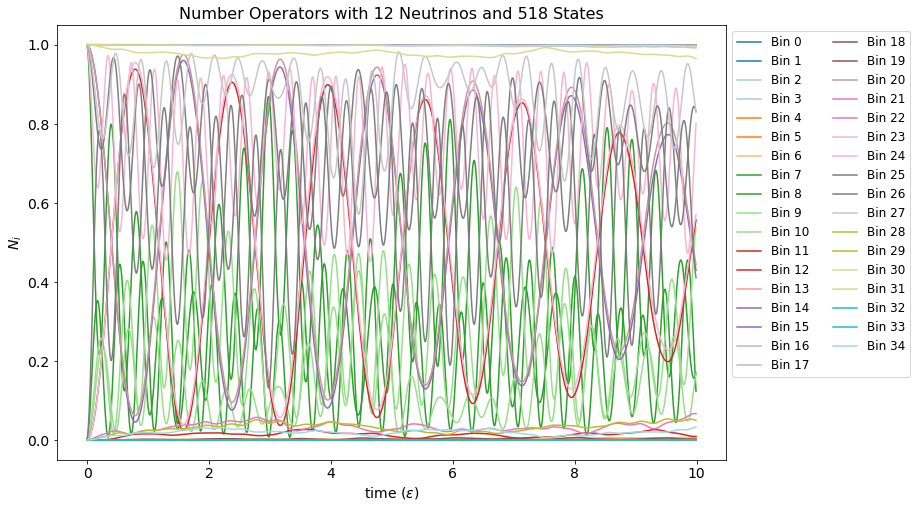

In [47]:
# plotting number operators
te.plot_number_operators(file_path)


## 10 Neutrinos, 192 States

In [48]:
# setting file path 
file_path = os.path.join(file_dir, 'N10_s192')

# loading in state information
config = StateConfig(file_path)
print(config, '\n')

# printing the activated states
config.print_basis()


Number of neutrinos: 10
Initial state: [ 0  3  4 15 20 24 26 27 28 31]
Activated bins: [0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 31, 32, 33, 34] 

For 10 neutrinos with an initial state of [0,3,4,15,20,24,26,27,28,31], 192 states are activated:
0th state: (0,3,4,15,20,24,26,27,28,31)
1th state: (0,3,6,15,20,24,26,27,28,29)
2th state: (0,3,4,15,20,21,27,28,29,31)
3th state: (0,3,4,15,20,21,26,27,28,34)
4th state: (0,3,4,15,20,22,24,26,31,33)
5th state: (0,3,6,15,20,22,24,26,29,33)
6th state: (0,3,4,15,20,21,22,29,31,33)
7th state: (2,3,4,15,20,21,26,27,28,32)
8th state: (0,3,4,15,20,21,22,26,33,34)
9th state: (1,3,4,15,20,22,24,26,31,32)
10th state: (0,4,6,15,20,22,24,26,28,33)
11th state: (1,3,6,15,20,22,24,26,29,32)
12th state: (1,3,4,15,20,21,22,29,31,32)
13th state: (0,4,6,15,20,21,22,28,29,33)
14th state: (2,3,4,15,20,21,22,26,32,33)
15th state: (1,3,4,15,20,21,22,26,32,34)
16th state: (1,4,6,15,20,22,24,26,28,32)
17th state: (0,2,9,15

In [49]:
%%time

# creating Hamiltonian object and diagonalizing
hamiltonian = Hamiltonian(momenta, config, dt)


Constructing 0th column of the Hamiltonian
Constructing 50th column of the Hamiltonian
Constructing 100th column of the Hamiltonian
Constructing 150th column of the Hamiltonian
CPU times: user 37.5 s, sys: 105 ms, total: 37.6 s
Wall time: 37.5 s


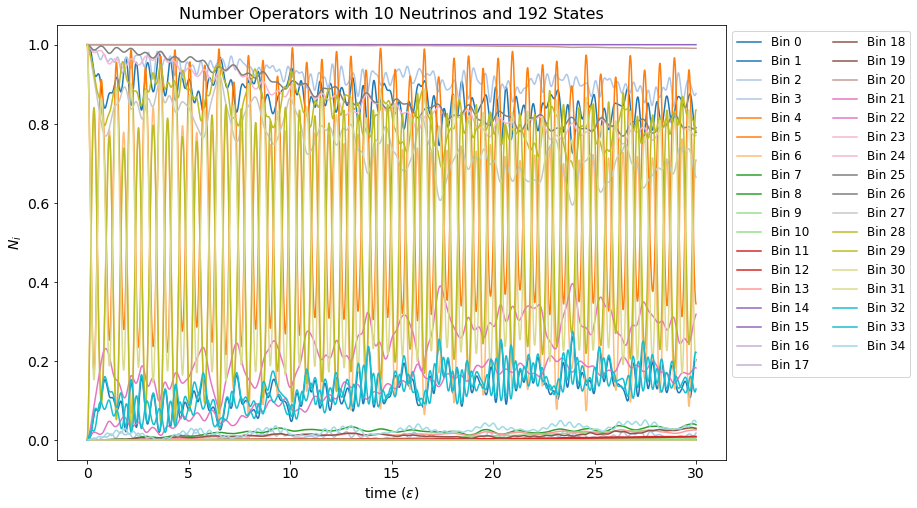

CPU times: user 30.9 s, sys: 8.42 s, total: 39.3 s
Wall time: 7.19 s


In [52]:
%%time

# creating a time-evolution object which computes probability amplitude and number operators
te = TimeEvolution(init_state, 3000, hamiltonian)

# plotting number operators
te.plot_number_operators(file_path)


## 10 Neutrinos, 25 States

In [53]:
# setting file path 
file_path = os.path.join(file_dir, 'N10_s25')

# loading in state information
config = StateConfig(file_path)
print(config, '\n')

# printing the activated states
config.print_basis()


Number of neutrinos: 10
Initial state: [ 0  2  8 15 17 20 25 27 28 31]
Activated bins: [0, 1, 2, 3, 6, 8, 10, 11, 13, 15, 16, 17, 18, 19, 20, 22, 25, 27, 28, 31, 32, 33, 34] 

For 10 neutrinos with an initial state of [0,2,8,15,17,20,25,27,28,31], 25 states are activated:
0th state: (0,2,8,15,17,20,25,27,28,31)
1th state: (0,2,8,15,17,20,22,25,31,33)
2th state: (1,2,8,15,17,20,22,25,31,32)
3th state: (0,3,8,15,17,19,20,25,31,33)
4th state: (0,1,8,15,17,20,22,25,31,34)
5th state: (1,3,8,15,17,19,20,25,31,32)
6th state: (0,6,8,15,17,19,20,25,28,33)
7th state: (0,3,8,16,17,18,20,25,31,33)
8th state: (1,6,8,15,17,19,20,25,28,32)
9th state: (1,3,8,16,17,18,20,25,31,32)
10th state: (0,6,8,16,17,18,20,25,28,33)
11th state: (0,6,8,13,15,17,20,25,33,34)
12th state: (1,6,8,16,17,18,20,25,28,32)
13th state: (1,6,8,13,15,17,20,25,32,34)
14th state: (2,6,8,13,15,17,20,25,32,33)
15th state: (0,6,8,11,15,17,22,25,33,34)
16th state: (3,6,8,10,15,17,20,25,32,34)
17th state: (1,6,8,11,15,17,22,25,32,34)

In [54]:
%%time

# creating Hamiltonian object and diagonalizing
hamiltonian = Hamiltonian(momenta, config, dt)


Constructing 0th column of the Hamiltonian
CPU times: user 4.9 s, sys: 19.9 ms, total: 4.92 s
Wall time: 4.95 s


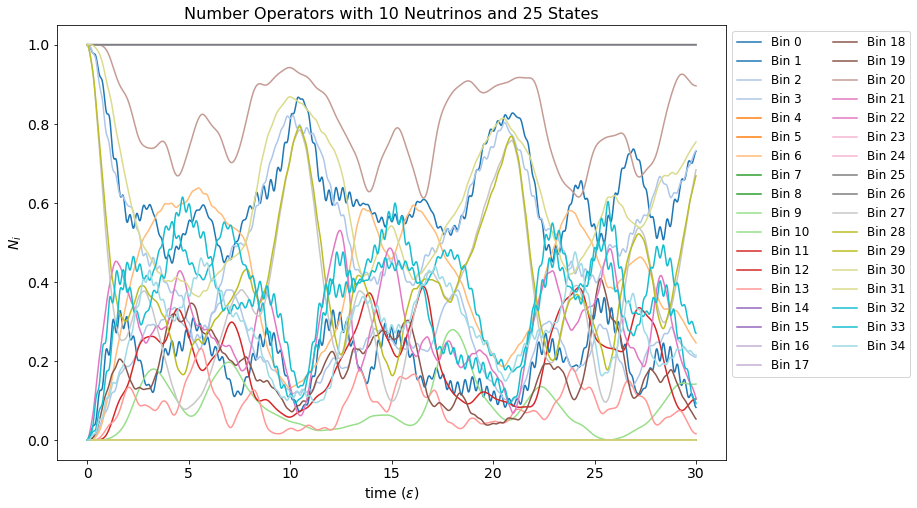

CPU times: user 1.33 s, sys: 30.4 ms, total: 1.36 s
Wall time: 1.39 s


In [56]:
%%time

# creating a time-evolution object which computes probability amplitude and number operators
te = TimeEvolution(init_state, 3000, hamiltonian)

# plotting number operators
te.plot_number_operators(file_path)


## 10 Neutrinos, 9 States

In [60]:
# setting file path 
file_path = os.path.join(file_dir, 'N10_s9')

# loading in state information
config = StateConfig(file_path)
print(config, '\n')

# printing the activated states
config.print_basis()


Number of neutrinos: 10
Initial state: [ 0  1  8 15 17 24 25 27 28 31]
Activated bins: [0, 1, 2, 3, 8, 15, 16, 17, 18, 19, 21, 22, 24, 25, 27, 28, 31, 32, 33, 34] 

For 10 neutrinos with an initial state of [0,1,8,15,17,24,25,27,28,31], 9 states are activated:
0th state: (0,1,8,15,17,24,25,27,28,31)
1th state: (0,1,8,15,17,21,25,27,28,34)
2th state: (0,1,8,15,17,22,24,25,31,33)
3th state: (1,2,8,15,17,21,25,27,28,32)
4th state: (0,2,8,15,17,21,25,27,28,33)
5th state: (0,1,8,15,17,21,22,25,33,34)
6th state: (1,2,8,15,17,21,22,25,32,33)
7th state: (1,3,8,15,17,19,21,25,32,33)
8th state: (1,3,8,16,17,18,21,25,32,33)


In [61]:
%%time

# creating Hamiltonian object and diagonalizing
hamiltonian = Hamiltonian(momenta, config, dt)


Constructing 0th column of the Hamiltonian
CPU times: user 1.78 s, sys: 3.2 ms, total: 1.79 s
Wall time: 1.79 s


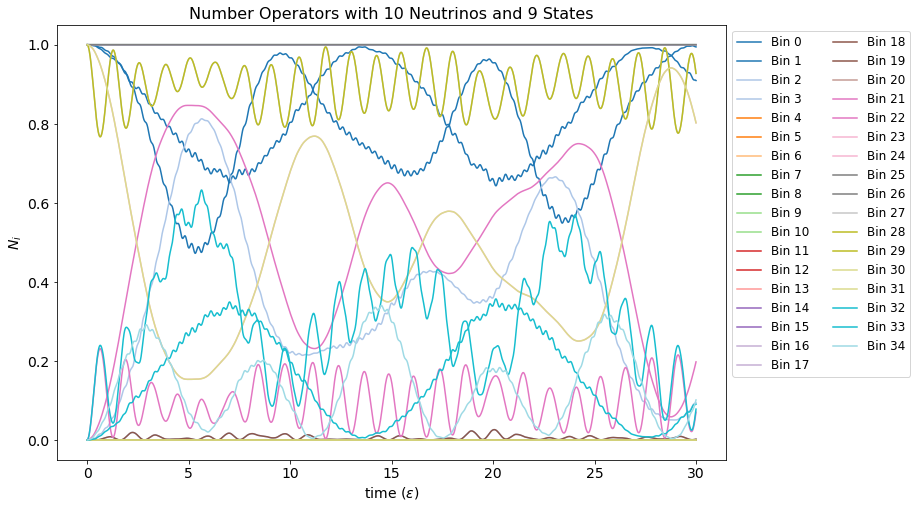

CPU times: user 892 ms, sys: 44.5 ms, total: 936 ms
Wall time: 988 ms


In [62]:
%%time

# creating a time-evolution object which computes probability amplitude and number operators
te = TimeEvolution(init_state, 3000, hamiltonian)

# plotting number operators
te.plot_number_operators(file_path)
